In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy

from data.dataloader import get_jhu_data, get_covid19india_api_data
from data.processing import get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from utils.plotting import create_plots

## Load Covid19india Data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes['df_raw_data'].groupby('detecteddistrict').count()

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detectedstate,estimatedonsetdate,gender,nationality,notes,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
detecteddistrict,,,,,,,,,,,,,,,,,,,
,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645
Adilabad,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
Agar Malwa,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Agra,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374
Ahmadabad,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Godavari,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
Y.S.R Kadapa,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Y.S.R.,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55


## Process Covid19india Data

In [5]:
df_district = get_district_time_series(dataframes, state='Maharashtra', district='Mumbai')

## Create Train-Val Split

In [6]:
def train_val_split(df_district, val_rollingmean=False, val_size=5):
    df_true_fitting = copy.copy(df_district)
    df_true_fitting['total_infected'] = df_true_fitting['total_infected'].rolling(5, center=True).mean()
    df_true_fitting = df_true_fitting[np.logical_not(df_true_fitting['total_infected'].isna())]
    df_true_fitting.reset_index(inplace=True, drop=True)
    
    df_train = df_true_fitting.iloc[:-(val_size-2), :]
    df_train = pd.concat([df_true_fitting.iloc[:-val_size, :], df_district.iloc[-(val_size+2):-val_size, :]], ignore_index=True)
    if val_rollingmean:
        df_val = pd.concat([df_true_fitting.iloc[-(val_size-2):, :], df_district.iloc[-2:, :]], ignore_index=True)
    else:
        df_val = df_district.iloc[-val_size:, :]
    df_val.reset_index(inplace=True, drop=True)
    return df_train, df_val, df_true_fitting

In [58]:
def fit_district(dataframes, state, district):
    df_district = get_district_time_series(dataframes, state=state, district=district)
    if district == None:
        district = ''
        
    # Get train val split
    df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=5)

    print('train\n', df_train.tail())
    print('val\n', df_val)

    # Initialise Optimiser
    optimiser = Optimiser()
    
    # Get the fixed params
    default_params = optimiser.init_default_params(df_train)

    # Create searchspace of variable params
    variable_param_ranges = {
        'R0' : hp.uniform('R0', 1.6, 5),
        'T_inc' : hp.uniform('T_inc', 4, 5),
        'T_inf' : hp.uniform('T_inf', 3, 4),
        'T_recov_severe' : hp.uniform('T_recov_severe', 9, 20),
        'P_severe' : hp.uniform('P_severe', 0.3, 0.99),
        'intervention_amount' : hp.uniform('intervention_amount', 0, 1)
    }
    
    # Perform Bayesian Optimisation
    best, trials = optimiser.bayes_opt(df_train, default_params, variable_param_ranges, method='rmse', num_evals=1500, loss_indices=[-10, None])

    print('best parameters\n', best)
    
    # Get Predictions dataframe
    df_prediction = optimiser.solve(best, default_params, df_train)

    # Create plots
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_district['date'], df_district['total_infected'], label='Confirmed Cases (Observed)')
    ax.plot(df_true_fitting['date'], df_true_fitting['total_infected'], label='Confirmed Cases (Rolling Avg(5))')
    ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['total_infected']), max(df_val['total_infected'])], '--r', label='Train Test Boundary')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('Rolling Avg vs Observed ({} {})'.format(state, district))
    plt.grid()
#     plt.savefig('../../plots/observed_{}_{}.png'.format(state, district))
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_train['date'], df_train['total_infected'], color='orange', label='Confirmed Cases (Rolling Avg (5))')
    ax.plot(df_prediction['date'], df_prediction['total_infected'], '-g', label='Confirmed Cases (Predicted)')
    ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['total_infected']), max(df_val['total_infected'])], '--r', label='Train Test Boundary')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('Total Confirmed Cases ({} {})'.format(state, district))
    plt.grid()
#     plt.savefig('../../plots/predictions_{}_{}.png'.format(state, district))
    plt.show()
    
    return best, default_params, optimiser, df_prediction, df_district


In [59]:
district_to_plot = [['Rajasthan', 'Jaipur'], ['Maharashtra', 'Mumbai'], ['Maharashtra', 'Pune'], ['Delhi', None], ['Karnataka', 'Bengaluru'], ['Gujarat', 'Ahmadabad']]

In [76]:
predictions_dict = {}

for state, district in district_to_plot:
    print('state - {}, district - {}'.format(state, district))
    best, default_params, optimiser, df_prediction, df_district = fit_district(dataframes, state, district)
    predictions_dict[(state, district)] = {}
    for name in ['best', 'default_params', 'optimiser', 'df_prediction', 'df_district']:
        predictions_dict[(state, district)][name] = eval(name)
    

state - Rajasthan, district - Jaipur
train
          date  total_infected
36 2020-04-17           503.4
37 2020-04-18           523.8
38 2020-04-19           558.0
39 2020-04-20           585.0
40 2020-04-21           657.0
val
         date  total_infected
0 2020-04-22             725
1 2020-04-23             740
2 2020-04-24             776
3 2020-04-25             791
4 2020-04-26             808
 22%|██▏       | 330/1500 [01:16<04:30,  4.33trial/s, best loss: 32.554210803407926]


KeyboardInterrupt: 

In [61]:
df_temp = predictions_dict[('Maharashtra', 'Mumbai')]['df_district']
df_temp.set_index('date', inplace=True)
df_temp.loc['2020-04-18', 'total_infected'] = 2085
df_temp.loc['2020-04-19', 'total_infected'] = 2268
df_temp.loc['2020-04-20', 'total_infected'] = 2724
df_temp.loc['2020-04-21', 'total_infected'] = 3032
df_temp.loc['2020-04-22', 'total_infected'] = 3451
df_temp.reset_index(inplace=True)
predictions_dict[('Maharashtra', 'Mumbai')]['df_district'] = df_temp
predictions_dict[('Maharashtra', 'Mumbai')]['df_district']

,date,total_infected
0,2020-03-11,2
1,2020-03-12,4
2,2020-03-13,4
3,2020-03-14,5
4,2020-03-15,5
5,2020-03-16,6
6,2020-03-17,7
7,2020-03-18,8
8,2020-03-19,9
9,2020-03-20,11


In [57]:
predictions_dict_final = copy.deepcopy(predictions_dict)

In [71]:
def create_classification_report(predictions_dict):
    
    df_result = pd.DataFrame(columns=['state', 'district', 'train_rmse', 'train_mape', 'pre_intervention_r0', 'post_intervention_r0',
                                      'val_rmse_observed', 'val_mape_observed', 'val_rmse_rolling', 'val_mape_rolling'])
    
    loss_calculator = Loss_Calculator()
    for i, key in enumerate(predictions_dict.keys()):
        df_result.loc[i, 'state'] = key[0]
        df_result.loc[i, 'district'] = key[1]
        df_district = predictions_dict[key]['df_district']
        df_prediction = predictions_dict[key]['df_prediction']
        best = predictions_dict[key]['best']
        optimiser = predictions_dict[key]['optimiser']
        default_params = predictions_dict[key]['default_params']
        
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=5)

        loss = loss_calculator._calc_mape(df_prediction.iloc[-10:, :]['total_infected'], df_train.iloc[-10:, :]['total_infected'])
        df_result.loc[i, 'train_mape'] = loss
        loss = loss_calculator._calc_rmse(df_prediction['total_infected'], df_train['total_infected'])
        df_result.loc[i, 'train_rmse'] = loss

        df_result.loc[i, 'pre_intervention_r0'] = best['R0']
        df_result.loc[i, 'post_intervention_r0'] = best['R0']*best['intervention_amount']

        normalising_ratio = (df_train['total_infected'].iloc[-1] / df_prediction['total_infected'].iloc[-1])
        df_prediction = optimiser.solve(best, default_params, df_train, end_date=df_val.iloc[-1, :]['date'])
        df_prediction.loc[df_prediction['date'] == df_prediction.iloc[-1]['date'], 'total_infected'] = df_prediction.loc[ df_prediction['date'] == df_prediction.iloc[-1]['date'], 'total_infected'] * normalising_ratio
        df_prediction.loc[df_prediction['date'].isin(df_val['date']), 'total_infected'] = df_prediction.loc[ df_prediction['date'].isin(df_val['date']), 'total_infected'] * normalising_ratio
        df_prediction = df_prediction[df_prediction['date'].isin(df_val['date'])]
        df_prediction.reset_index(inplace=True, drop=True)

        loss = loss_calculator._calc_mape(df_prediction['total_infected'], df_val['total_infected'])
        df_result.loc[i, 'val_mape_observed'] = loss
        loss = loss_calculator._calc_rmse(df_prediction['total_infected'], df_val['total_infected'])
        df_result.loc[i, 'val_rmse_observed'] = loss

        _, df_val, _ = train_val_split(df_district, val_rollingmean=True, val_size=5)

        loss = loss_calculator._calc_mape(df_prediction['total_infected'], df_val['total_infected'])
        df_result.loc[i, 'val_mape_rolling'] = loss
        loss = loss_calculator._calc_rmse(df_prediction['total_infected'], df_val['total_infected'])
        df_result.loc[i, 'val_rmse_rolling'] = loss
        
        df_result.loc[i, 'train_period'] = '{} to {}'.format(df_train['date'].iloc[-10].date(), df_train['date'].iloc[-1].date())
        df_result.loc[i, 'val_period'] = '{} to {}'.format(df_val['date'].iloc[0].date(), df_val['date'].iloc[-1].date())
        df_result.loc[i, 'init_date'] = '{}'.format(df_train['date'].iloc[0].date())

    return df_result

In [74]:
def create_full_plots(predictions_dict):
    for i, key in enumerate(predictions_dict.keys()):
        
        df_district = predictions_dict[key]['df_district']
        df_prediction = predictions_dict[key]['df_prediction']
        best = predictions_dict[key]['best']
        optimiser = predictions_dict[key]['optimiser']
        default_params = predictions_dict[key]['default_params']
        
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=5)
        
        # Create state init values before solving on val set
        last_prediction = df_prediction.iloc[-1, 1:12]
        normalising_ratio = (df_train['total_infected'].iloc[-1] / df_prediction['total_infected'].iloc[-1])
        last_prediction[1:] = list(map(lambda x : int(round(x)), df_prediction.iloc[-1, 2:12] * normalising_ratio))
        last_prediction[0] = default_params['N'] - sum(last_prediction[1:])
        state_init_values = last_prediction.to_dict(OrderedDict)
        
#         df_prediction = optimiser.solve(best, default_params, df_train, start_date=df_val.iloc[0, :]['date'], end_date=df_val.iloc[-1, :]['date'], 
#                                         state_init_values=state_init_values)
        df_prediction = optimiser.solve(best, default_params, df_train, end_date=df_val.iloc[-1, :]['date'])
        df_prediction.loc[df_prediction['date'] == df_prediction.iloc[-1]['date'], 'total_infected'] = df_prediction.loc[ df_prediction['date'] == df_prediction.iloc[-1]['date'], 'total_infected'] * normalising_ratio
        df_prediction.loc[df_prediction['date'].isin(df_val['date']), 'total_infected'] = df_prediction.loc[ df_prediction['date'].isin(df_val['date']), 'total_infected'] * normalising_ratio
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.plot(df_district['date'], df_district['total_infected'], label='Confirmed Cases (Observed)')
        ax.plot(df_true_fitting['date'], df_true_fitting['total_infected'], color='orange', label='Confirmed Cases (Rolling Avg (5))')
        ax.plot(df_prediction['date'], df_prediction['total_infected'], '-g', label='Confirmed Cases (Predicted)')
        ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['total_infected']), max(df_val['total_infected'])], '--r', label='Train Test Boundary')
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.ylabel('No of People')
        plt.xlabel('Time')
        plt.legend()
        plt.title('Total Confirmed Cases Extrapolated ({})'.format(key))
        plt.grid()
        plt.show()

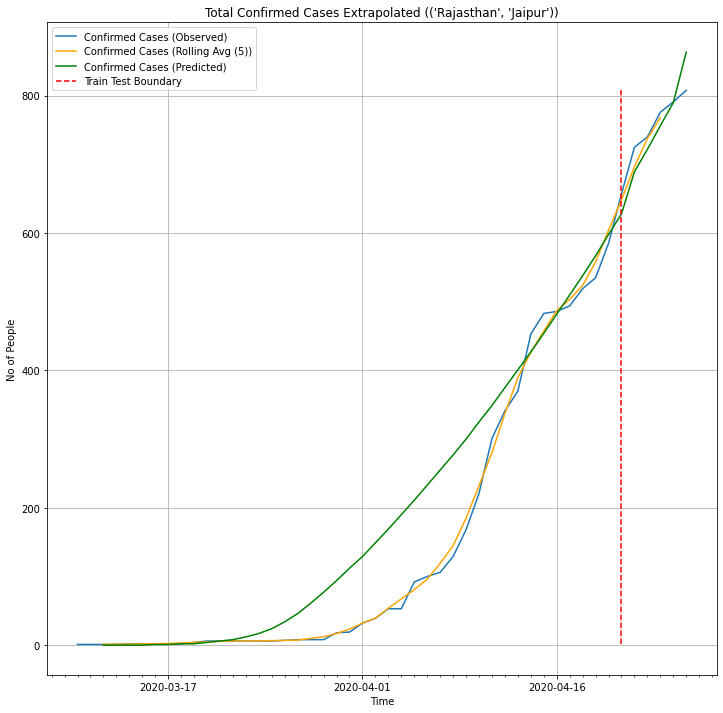

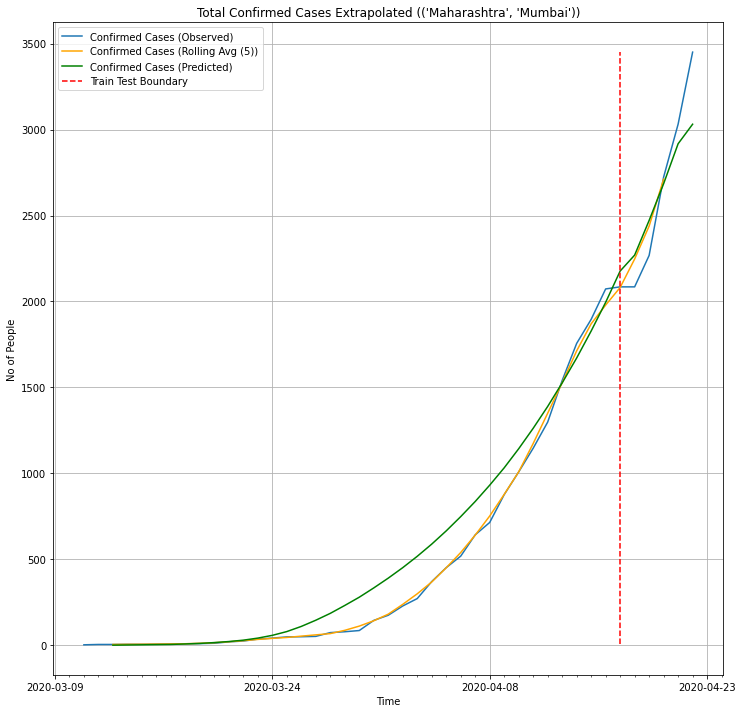

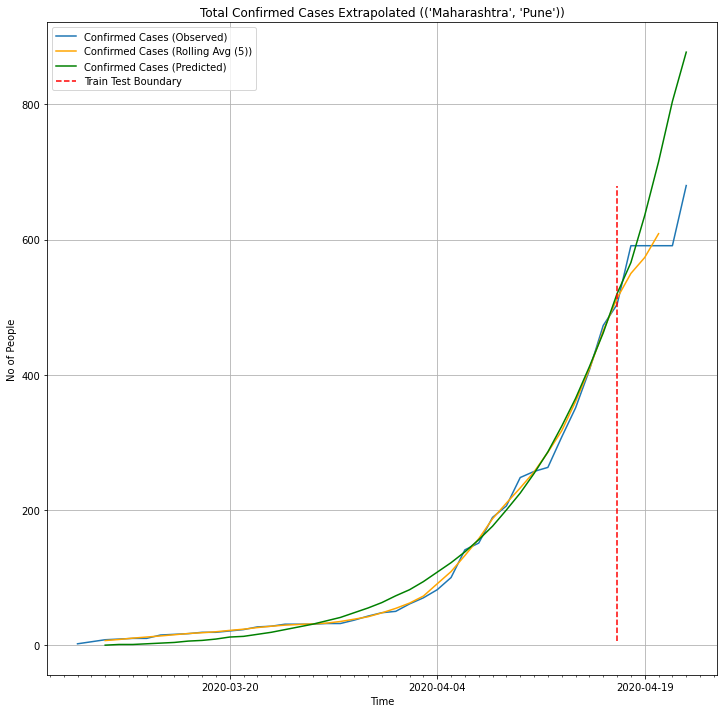

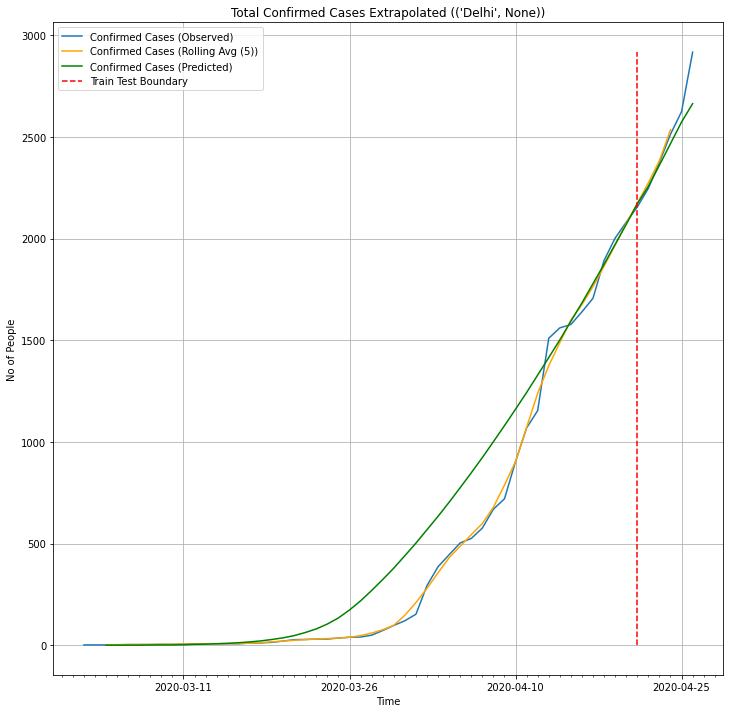

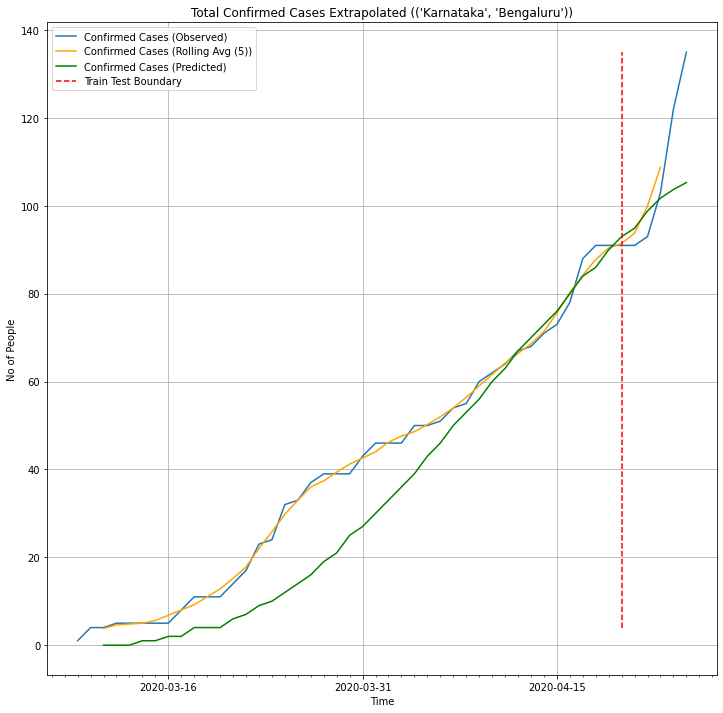

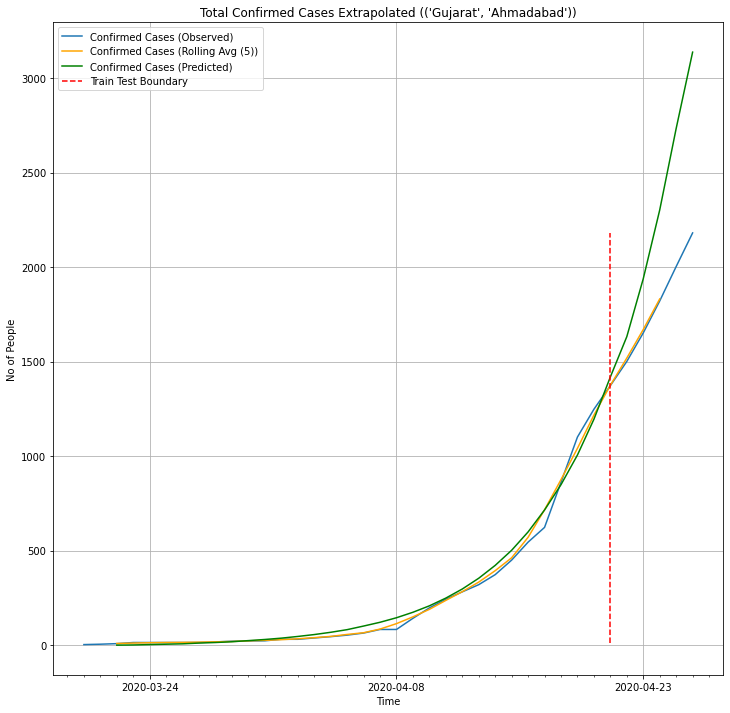

In [75]:
create_full_plots(predictions_dict)

In [72]:
df_result = create_classification_report(predictions_dict)
df_result

,state,district,train_rmse,train_mape,pre_intervention_r0,post_intervention_r0,val_rmse_observed,val_mape_observed,val_rmse_rolling,val_mape_rolling,train_period,val_period,init_date
0,Rajasthan,Jaipur,65.1998,2.82276,4.92656,1.1424,31.8309,3.38063,26.5614,2.344,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-12
1,Maharashtra,Mumbai,121.015,7.82484,4.91505,1.63146,230.711,7.03764,195.604,3.85419,2020-04-08 to 2020-04-17,2020-04-18 to 2020-04-22,2020-03-13
2,Maharashtra,Pune,10.6438,2.40635,2.3268,2.16038,143.259,19.5976,141.424,19.2805,2020-04-08 to 2020-04-17,2020-04-18 to 2020-04-22,2020-03-11
3,Delhi,None,158.749,1.46881,3.84248,1.12621,117.824,2.70113,120.398,3.01179,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-04
4,Karnataka,Bengaluru,9.78765,1.34173,2.16682,0.950292,15.9115,9.74738,15.9197,9.15915,2020-04-11 to 2020-04-20,2020-04-21 to 2020-04-25,2020-03-11
5,Gujarat,Ahmadabad,23.8034,4.67169,4.17388,2.79608,596.55,26.5671,592.432,25.9101,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-22


In [73]:
df_result.to_csv('../../result.csv')

In [ ]:
predictions_dict[('Maharashtra', 'Mumbai')]['best']